In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
# Load các bộ dữ liệu

base = r"C:\Downloads\Corn_data_merged_3_region"

# --- 1) Load 5 file chính ---
yield_df        = pd.read_csv(fr"{base}\Corn_yield_all_years_3region.csv")
progress_df     = pd.read_csv(fr"{base}\corn_progress_all_years_3region.csv")
condition_df    = pd.read_csv(fr"{base}\corn_condition_all_years_3region.csv")
weather_all_df  = pd.read_csv(fr"{base}\weather_weekly_all_years_3region.csv")
weather_season_df = pd.read_csv(fr"{base}\corn_weekly_merged.csv")  # file mùa vụ đã cắt theo progress

# làm tròn số + e cho diện tích thu hoặc và sản lượng
pd.options.display.float_format = '{:.2f}'.format

In [19]:
print("Kích thước dữ liệu:", yield_df.shape)
yield_df.info()


Kích thước dữ liệu: (360, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              360 non-null    int64  
 1   state_name        360 non-null    object 
 2   state_alpha       360 non-null    object 
 3   region            360 non-null    object 
 4   planted_all       360 non-null    int64  
 5   harvested_grain   360 non-null    int64  
 6   yield_grain       360 non-null    float64
 7   production_grain  360 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 22.6+ KB


In [20]:
cols_to_describe = ['harvested_grain', 'yield_grain',"production_grain"]
yield_df[cols_to_describe].describe(include='all').round(2)

,harvested_grain,yield_grain,production_grain
count,360.00,360.00,360.00
mean,3943211.94,142.92,636543458.33
std,3582911.71,37.33,675566782.97
min,235000.00,17.50,5330000.00
25%,1117500.00,122.00,144861250.00
50%,3000000.00,148.00,407107500.00
75%,5255000.00,171.00,799992500.00
max,13900000.00,217.00,2740500000.00


In [21]:
region_stats = yield_df.groupby('region')['yield_grain'].describe().round(2)
display(region_stats)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Semi-Arid Continental,120.00,113.81,36.76,17.50,90.40,121.40,137.12,194.00
Subtropical Humid,60.00,139.42,30.06,68.00,117.75,140.50,168.00,192.00
Temperate Humid,180.00,163.51,24.51,75.00,147.75,163.50,178.25,217.00


In [22]:
# Đếm số lượng bang (unique state_alpha) trong từng vùng
region_state_summary = (
    yield_df.groupby('region')['state_alpha']
    .agg(lambda x: sorted(x.unique()))  # Lấy danh sách mã bang sắp xếp
    .reset_index()
)

# Thêm cột số lượng bang
region_state_summary['num_states'] = region_state_summary['state_alpha'].apply(len)

# Hiển thị kết quả
print("Tổng hợp số lượng bang theo vùng:\n")
for _, row in region_state_summary.iterrows():
    region = row['region']
    num = row['num_states']
    states = ", ".join(row['state_alpha'])
    print(f"- {region}: {num} bang → {states}")


Tổng hợp số lượng bang theo vùng:

- Semi-Arid Continental: 6 bang → CO, KS, ND, NE, SD, TX
- Subtropical Humid: 3 bang → KY, NC, TN
- Temperate Humid: 9 bang → IA, IL, IN, MI, MN, MO, OH, PA, WI


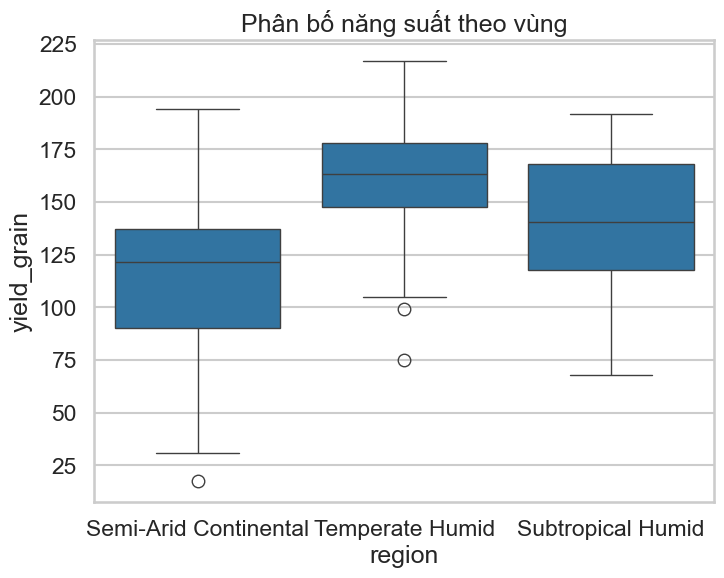

In [23]:
plt.figure(figsize=(8,6))
sns.boxplot(x='region', y='yield_grain', data=yield_df)
plt.title("Phân bố năng suất theo vùng")
plt.show()

In [24]:
#OUTLIER
# yield_df[yield_df['yield_grain'] < 50][['year','state_name', 'region', 'yield_grain']]

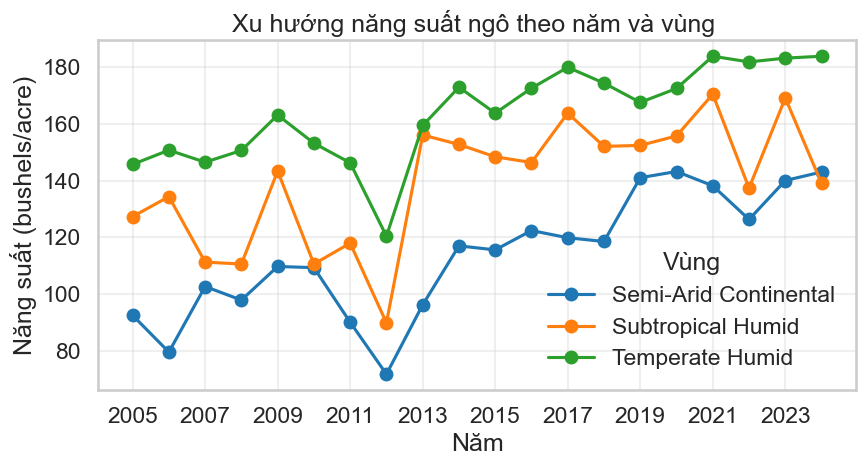

In [25]:
# Đảm bảo cột 'year' là số và không bị NaN
yield_df['year'] = pd.to_numeric(yield_df['year'], errors='coerce')
yield_df = yield_df.dropna(subset=['year', 'region', 'yield_grain'])
yield_df['year'] = yield_df['year'].astype(int)

# Gom trung bình năng suất theo vùng và năm
year_region = (
    yield_df.groupby(['year', 'region'], as_index=False)['yield_grain']
      .mean()
      .sort_values(['region', 'year'])
)
plt.figure(figsize=(9,5))

# Vẽ từng vùng bằng vòng lặp
for region, sub_df in year_region.groupby('region'):
    plt.plot(sub_df['year'], sub_df['yield_grain'], marker='o', label=region)

plt.title("Xu hướng năng suất ngô theo năm và vùng ")
plt.xlabel("Năm")
plt.ylabel("Năng suất (bushels/acre)")

# Làm tròn & chia khoảng đều cho trục năm
years = np.arange(year_region['year'].min(), year_region['year'].max() + 1, 2)
plt.xticks(years.astype(int))

plt.legend(title="Vùng", frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
# Tính hệ số tương quan Pearson
corr, pval = pearsonr(yield_df['harvested_grain'], yield_df['yield_grain'])

print("\n===========================")
print("HỆ SỐ TƯƠNG QUAN DIỆN TÍCH - NĂNG SUẤT")
print("===========================")
print(f"Hệ số tương quan Pearson: {corr:.3f}")



HỆ SỐ TƯƠNG QUAN DIỆN TÍCH - NĂNG SUẤT
Hệ số tương quan Pearson: 0.547


In [27]:
# weather_season_df['week_ending'] = pd.to_datetime(weather_season_df['week_ending'])
# weather_season_df['year'] = weather_season_df['year'].astype(int)

# # Tính trung bình mỗi năm cho từng vùng
# yearly_weather = (
#     weather_season_df.groupby(['year', 'region'], as_index=False)
#     [['tavg', 'tmax', 'tmin', 'prcp_sum', 'rh']]
#     .mean()
# )

# # Lấy các năm chẵn để hiển thị gọn trục X
# even_years = sorted([y for y in yearly_weather['year'].unique() if y % 2 == 0])

# # --- Vẽ biểu đồ xu hướng ---
# sns.set_style("whitegrid")
# sns.set_context("talk")

# plt.figure(figsize=(12,6))
# sns.lineplot(
#     data=yearly_weather,
#     x='year',
#     y='tavg',
#     hue='region',
#     marker='o',
#     linewidth=2.5,
#     palette='Set2'
# )

# # --- Tùy chỉnh biểu đồ ---
# plt.title("Xu hướng nhiệt độ trung bình (tavg) theo năm", fontsize=16, fontweight='bold')
# plt.xlabel("Năm", fontsize=12)
# plt.ylabel("Nhiệt độ trung bình (°C)", fontsize=12)
# plt.xticks(even_years)
# plt.grid(axis='y', linestyle='--', alpha=0.4)
# plt.legend(title="Vùng khí hậu", fontsize=10, title_fontsize=11)
# plt.tight_layout()

# plt.show()

In [28]:
# #Lượng mưa trung bình theo năm
# yearly_prcp = weather_season_df.groupby(['year', 'region'], as_index=False)[['prcp_sum']].mean()
# even_years = sorted([y for y in yearly_prcp['year'].unique() if y % 2 == 0])

# plt.figure(figsize=(12,6))
# sns.lineplot(data=yearly_prcp, x='year', y='prcp_sum', hue='region', marker='o', linewidth=2)
# plt.title("Tổng lượng mưa trung bình (prcp_sum) theo năm ")
# plt.xlabel("Năm")
# plt.ylabel("Lượng mưa trung bình (mm)")
# plt.legend(title="Vùng khí hậu")
# plt.grid(True, linestyle="--", alpha=0.4)
# plt.xticks(even_years)
# plt.show()

In [29]:
#Tính số tuần của từng giai đoạn
progress_df['week_ending'] = pd.to_datetime(progress_df['week_ending'], errors='coerce')
progress_df['week'] = progress_df['week'].astype(int)

# Thứ tự giai đoạn đúng quy trình sinh trưởng
stage_cols = ['planted', 'emerged', 'silking', 'doughing', 'dented', 'mature', 'harvested']

# 2. Tính trung bình từng tuần theo vùng
avg = (
    progress_df.groupby(['region', 'week'])[stage_cols]
      .mean()
      .reset_index()
)

# 3. Xác định tuần bắt đầu, kết thúc, và số tuần cho từng giai đoạn
rows = []
for region, g in avg.groupby('region'):
    for stage in stage_cols:     # duyệt đúng thứ tự đã định nghĩa
        sub = g[g[stage] > 0]
        if sub.empty:
            continue
        start_week = int(sub['week'].iloc[0])
        end_week = int(sub['week'].iloc[-1])
        duration = int(round(end_week - start_week))
        rows.append({
            'region': region,
            'stage': stage,
            'start_week': start_week,
            'end_week': end_week,
            'weeks': duration
        })

# 4. Giữ nguyên thứ tự stage theo danh sách gốc, không sort chữ cái
summary = pd.DataFrame(rows)
summary['stage'] = pd.Categorical(summary['stage'], categories=stage_cols, ordered=True)
summary = summary.sort_values(['region', 'stage'], key=lambda col: col.map({s: i for i, s in enumerate(stage_cols)}))

# 5. Pivot bảng (hàng = vùng, cột = giai đoạn)
summary_pivot = summary.pivot(index='region', columns='stage', values='weeks')

# 6. Làm tròn và hiển thị
summary_pivot = summary_pivot.round(0).astype('Int64')

summary_pivot

stage,planted,emerged,silking,doughing,dented,mature,harvested
region,,,,,,,
Semi-Arid Continental,21,17,18,16,18,19,39
Subtropical Humid,13,13,13,14,14,15,21
Temperate Humid,16,15,16,17,16,17,19


In [30]:
# Xác định cột giai đoạn (điền theo đúng tên cột trong file)
stage_cols = ['planted', 'emerged', 'silking', 'doughing', 'dented', 'mature', 'harvested']

# Lọc các dòng mà tất cả giai đoạn đều bằng 0
empty_weeks = progress_df[progress_df[stage_cols].sum(axis=1) == 0]

print(f"\nSố tuần không có tiến trình: {len(empty_weeks)}")
empty_weeks.head()


Số tuần không có tiến trình: 568


,year,state_name,state_alpha,region,week_ending,week,planted,emerged,silking,doughing,dented,mature,harvested
8,2005,COLORADO,CO,Semi-Arid Continental,2005-06-26,25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
37,2005,IOWA,IA,Temperate Humid,2005-06-26,25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
38,2005,IOWA,IA,Temperate Humid,2005-07-03,26,0.00,0.00,0.00,0.00,0.00,0.00,0.00
182,2005,MICHIGAN,MI,Temperate Humid,2005-06-26,25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
183,2005,MICHIGAN,MI,Temperate Humid,2005-07-03,26,0.00,0.00,0.00,0.00,0.00,0.00,0.00


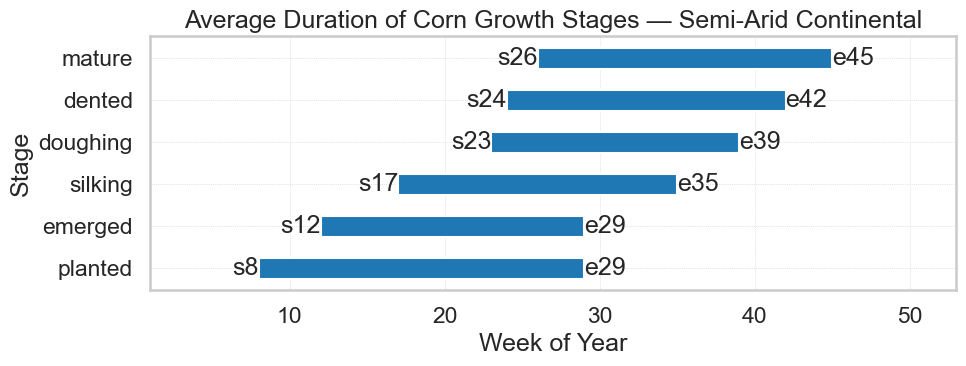

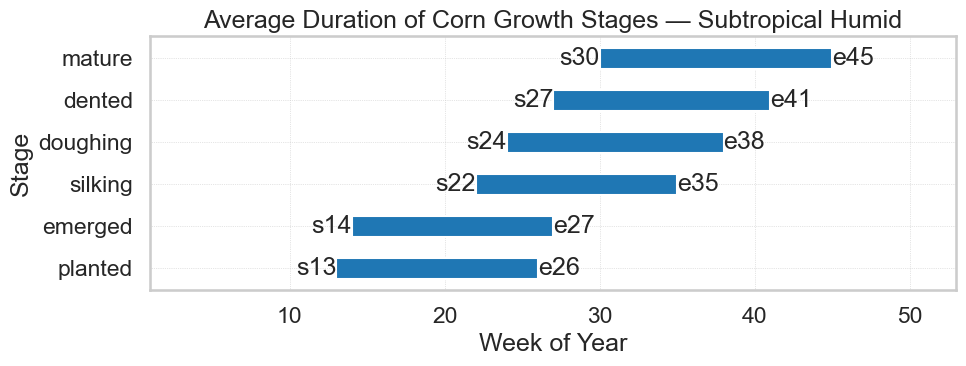

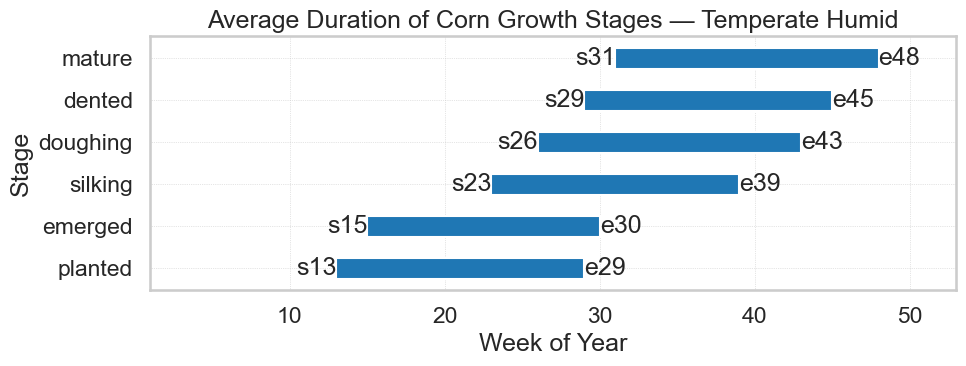

In [31]:
stage_cols = ['planted', 'emerged', 'silking', 'doughing', 'dented', 'mature']

def plot_stage_by_region(region_name, df_region):
    df_region = df_region.copy()

    # Bỏ giá trị thiếu hoặc sai kiểu
    df_region = df_region[df_region['stage'].notna()].copy()
    df_region['stage'] = df_region['stage'].astype(str)

    # Giữ thứ tự giai đoạn thực tế có trong dữ liệu
    valid_stages = [s for s in stage_cols if s in df_region['stage'].unique()]
    if not valid_stages:
        print(f" Region {region_name}: không có stage hợp lệ, bỏ qua.")
        return

    # Lọc chỉ các stage hợp lệ
    df_region = df_region[df_region['stage'].isin(valid_stages)].copy()

    # Sắp xếp stage theo đúng thứ tự stage_cols
    df_region['stage'] = pd.Categorical(df_region['stage'], categories=valid_stages, ordered=True)
    df_region = df_region.sort_values('stage')

    # Đảm bảo dữ liệu số không chứa NaN (tránh lỗi khi plot)
    for col in ['weeks', 'start_week', 'end_week']:
        df_region[col] = pd.to_numeric(df_region[col], errors='coerce').fillna(0)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 4))
    plt.barh(df_region['stage'], df_region['weeks'], left=df_region['start_week'], height=0.5)

    # Thêm nhãn bắt đầu & kết thúc
    for stage, s, e in zip(df_region['stage'], df_region['start_week'], df_region['end_week']):
        plt.text(s, stage, f"s{s:.0f}", va='center', ha='right')
        plt.text(e, stage, f"e{e:.0f}", va='center', ha='left')

    plt.title(f"Average Duration of Corn Growth Stages — {region_name}")
    plt.xlabel("Week of Year")
    plt.ylabel("Stage")
    plt.xlim(1, 53)
    plt.grid(True, axis='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ cho từng vùng
for region_name, sub in summary.groupby('region'):
    plot_stage_by_region(region_name, sub)

In [32]:
# print(" Hệ số tương quan giữa tavg, prcp_sum và rh:")
# weather_season_df['week_ending'] = pd.to_datetime(weather_season_df['week_ending'])
# weather_season_df['year'] = weather_season_df['year'].astype(int)

# # Chọn 3 biến cần phân tích
# data = weather_season_df[['tavg', 'prcp_sum', 'rh']]

# # =======================================
# # Tính hệ số tương quan (Pearson)
# # =======================================
# corr_matrix = data.corr(method='pearson')


# print(corr_matrix)

# # =======================================
# #  Trực quan hóa ma trận tương quan
# # =======================================
# plt.figure(figsize=(6,5))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title("Tương quan giữa Nhiệt độ trung bình, Lượng mưa và Độ ẩm")
# plt.tight_layout()
# plt.show()

C:\Users\dhoan\AppData\Local\Temp\ipykernel_12380\4254683333.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{st}_m50": first_month_reach_50(g, st) for st in stage_cols}))


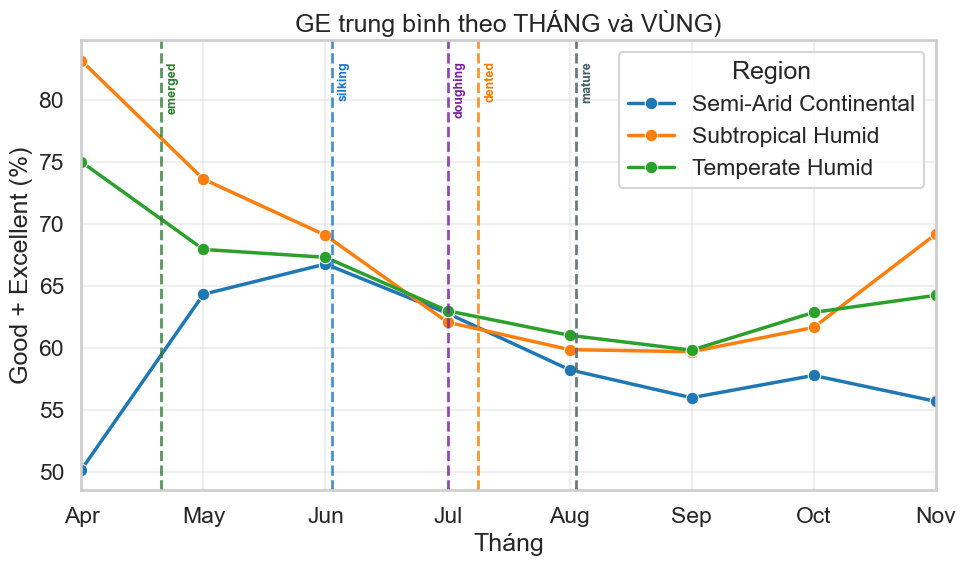

In [33]:
# -------- Load & clean --------
df = weather_season_df
df["week_ending"] = pd.to_datetime(df["week_ending"], errors="coerce")
df = df[df["flag_condition_progress"] == 0].copy()

stage_cols = ["emerged","silking","doughing","dented","mature"]
cond_cols  = ["excellent","good","fair","poor","very poor"]
df.replace({"(D)": np.nan, "(NA)": np.nan, "(X)": np.nan, "(Z)": 0}, inplace=True)
for c in stage_cols + cond_cols + ["week"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# bỏ tuần rỗng giai đoạn
df = df[(df[stage_cols].sum(axis=1) > 0)].copy()

df["GE"]    = df["good"] + df["excellent"]
df["month"] = df["week_ending"].dt.month.astype(int)   # <- BẮT BUỘC là số
MONTHS = list(range(4, 12))
df = df[df["month"].isin(MONTHS)]

# -------- GE theo THÁNG & VÙNG (trung bình qua năm) --------
region_month = (
    df.groupby(["region","year","month"], as_index=False)[["GE"]].mean() # chỉ cột số
      .groupby(["region","month"], as_index=False)[["GE"]].mean()
      .sort_values(["region","month"])
)


def first_month_reach_50(g, col):
    hit = g.loc[g[col] >= 50, "month"]
    return int(hit.min()) if not hit.empty else np.nan

marks_all = (
    df.groupby("year", as_index=False)
      .apply(lambda g: pd.Series({f"{st}_m50": first_month_reach_50(g, st) for st in stage_cols}))
      .drop(columns="year")
      .melt(var_name="stage_m50", value_name="month")
      .dropna()
)
marks_all["stage"] = marks_all["stage_m50"].str.replace("_m50","",regex=False)
marks_all = (marks_all.groupby("stage", as_index=False)["month"].mean()
                        .sort_values("month"))

stage_colors = {
    "emerged":"#2E7D32","silking":"#1976D2",
    "doughing":"#7B1FA2","dented":"#F57C00","mature":"#455A64"
}

# -------- Plot --------
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.lineplot(data=region_month, x="month", y="GE", hue="region",
             marker="o", linewidth=2.5, sort=True)

# vạch dọc mốc stage (50%)
ymax = plt.ylim()[1]
for _, r in marks_all.iterrows():
    m, st = float(r["month"]), r["stage"]
    plt.axvline(m, ls="--", c=stage_colors.get(st,"gray"), lw=2, alpha=0.8)
    plt.text(m+0.05, ymax*0.98, st, rotation=90, color=stage_colors.get(st,"gray"),
             va="top", ha="left", fontsize=9, fontweight="bold")

# trục X = THÁNG (số), nhãn = tên
month_labels = {4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov"}
plt.xlim(4, 11)
plt.xticks(MONTHS, [month_labels[m] for m in MONTHS])

plt.xlabel("Tháng")
plt.ylabel("Good + Excellent (%)")
plt.title("GE trung bình theo THÁNG và VÙNG)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

C:\Users\dhoan\AppData\Local\Temp\ipykernel_12380\3753858854.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Vùng khí hậu", fontsize=10, title_fontsize=11, loc='upper right')


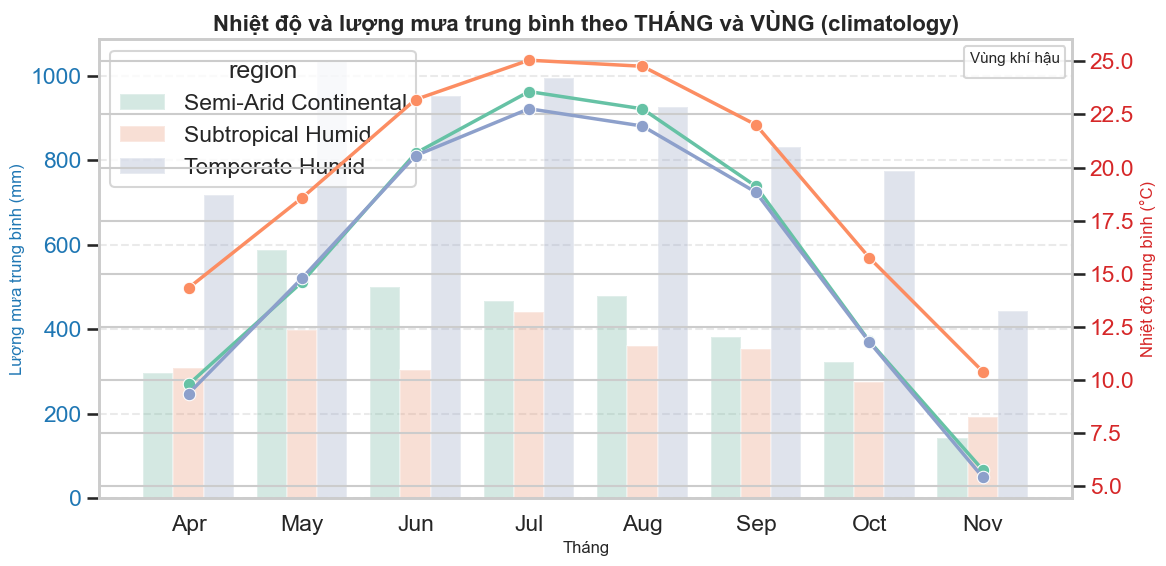

In [34]:
weather_season_df['week_ending'] = pd.to_datetime(weather_season_df['week_ending'])
weather_season_df['year'] = weather_season_df['week_ending'].dt.year.astype(int)
weather_season_df['month'] = weather_season_df['week_ending'].dt.month

# Gom tuần -> tháng -> năm -> vùng
monthly_per_year = (
    weather_season_df
    .groupby(['year', 'region', 'month'], as_index=False)
    .agg({
        'tavg': 'mean',
        'tmax': 'mean',
        'tmin': 'mean',
        'rh':   'mean',
        'prcp_sum': 'sum'   # tổng lượng mưa trong tháng
    })
)

# Trung bình qua các năm (climatology)
monthly_climo = (
    monthly_per_year
    .groupby(['region', 'month'], as_index=False)
    .agg({
        'tavg': 'mean',
        'prcp_sum': 'mean'
    })
)

# --- Thêm nhãn tháng ---
month_labels = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
                7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
monthly_climo['month_label'] = monthly_climo['month'].map(month_labels)

# Chỉ giữ mùa trồng trọt
season_months = [4,5,6,7,8,9,10,11]
monthly_climo = monthly_climo[monthly_climo['month'].isin(season_months)]
order_labels = [month_labels[m] for m in season_months]
monthly_climo['month_label'] = pd.Categorical(monthly_climo['month_label'],
                                              categories=order_labels, ordered=True)

# --- Vẽ biểu đồ ---
sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax1 = plt.subplots(figsize=(12,6))

# Biểu đồ CỘT cho lượng mưa (prcp_sum)
sns.barplot(
    data=monthly_climo,
    x='month_label',
    y='prcp_sum',
    hue='region',
    palette='Set2',
    alpha=0.3,
    ax=ax1
)
ax1.set_ylabel("Lượng mưa trung bình (mm)", fontsize=12, color='tab:blue')
ax1.set_xlabel("Tháng", fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Biểu đồ ĐƯỜNG cho nhiệt độ trung bình (tavg)
ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_climo.sort_values('month'),
    x='month_label', y='tavg',
    hue='region', marker='o', linewidth=2.5,
    palette='Set2', ax=ax2, legend=False
)
ax2.set_ylabel("Nhiệt độ trung bình (°C)", fontsize=12, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# --- Tùy chỉnh ---
plt.title("Nhiệt độ và lượng mưa trung bình theo THÁNG và VÙNG (climatology)", fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Vùng khí hậu", fontsize=10, title_fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()